### 2373, Андреев Никита
#### Продолжаем работать с предыдущим датасетом

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pandas.plotting import scatter_matrix
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("ship_fuel_efficiency.csv")
df = df.drop(columns='ship_id')
df = df.drop(columns='route_id')
df.head(n=10)

,ship_type,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,Oil Service Boat,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,Oil Service Boat,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,Oil Service Boat,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,Oil Service Boat,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,Oil Service Boat,May,134.32,HFO,4267.19,11617.03,Calm,85.61
5,Oil Service Boat,June,85.93,Diesel,2342.13,6753.42,Stormy,72.82
6,Oil Service Boat,July,85.67,HFO,2974.79,8498.16,Moderate,93.93
7,Oil Service Boat,August,44.81,Diesel,1376.38,3509.56,Moderate,91.10
8,Oil Service Boat,September,116.44,Diesel,3661.75,9423.97,Calm,73.41
9,Oil Service Boat,October,99.73,HFO,2551.99,6416.66,Moderate,94.68


Добавляем новый атрибут на основе отношения выбросов CO₂ к расстоянию рейса, чтобы отразить экологическую эффективность рейса. Назовём его CO2_per_km (выбросы CO₂ на 1 км пути).

**CO2_per_km = CO2_emissions / distance**


In [126]:

df['CO2_per_km'] = df['CO2_emissions'] / df['distance']
df[['distance', 'CO2_emissions', 'CO2_per_km']].head()

,distance,CO2_emissions,CO2_per_km
0,132.26,10625.76,80.339936
1,128.52,12779.73,99.437675
2,67.30,5353.01,79.539525
3,71.68,6506.52,90.771763
4,134.32,11617.03,86.487716


#### Проведём работу с датасетом: пробуем найти дубли и выбросы

In [ ]:
duplicate = df[df.duplicated()]
duplicate.head()

,ship_type,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency,CO2_per_km


Как видим, дубликатов не оказалось

Определим наличие выбросов с помощью диаграммы размаха

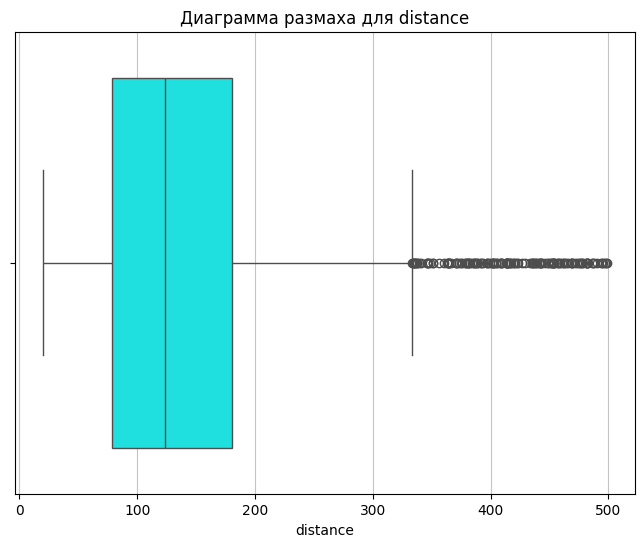

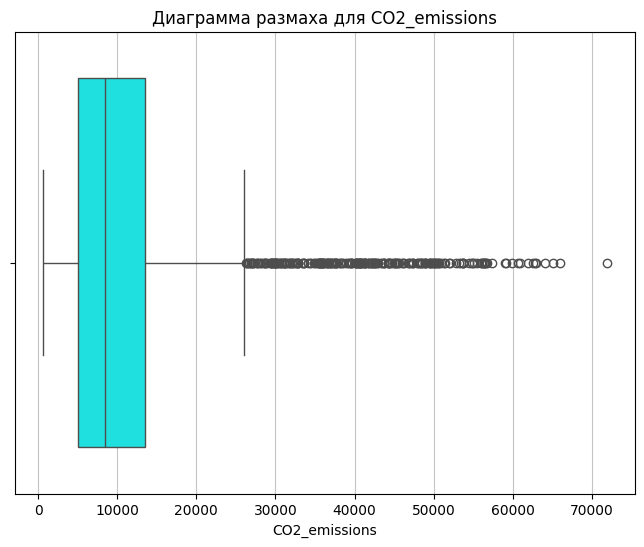

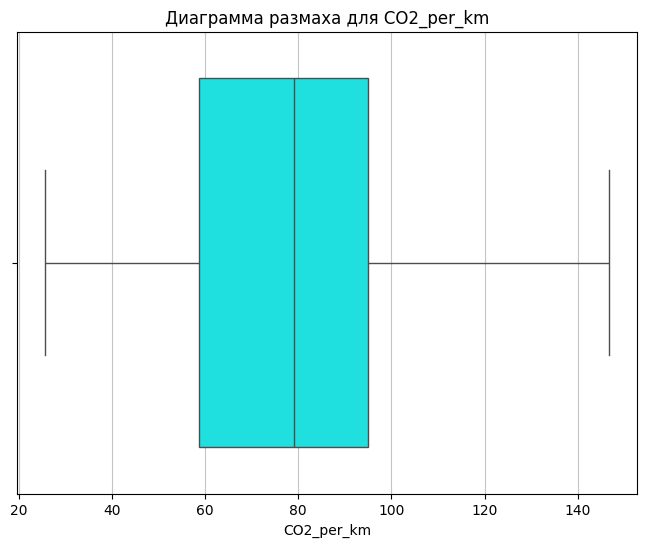

In [128]:
eco_features = ['distance', 'CO2_emissions', 'CO2_per_km']

for feature in eco_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature], color='cyan')
    plt.title(f'Диаграмма размаха для {feature}')
    plt.xlabel(feature)
    plt.grid(axis='x', alpha=0.75)
    plt.show()

Первые две диаграммы содержат большое количество выбросов. 

Однако, на диаграмме нового признака CO2_per_km выбросов нет совсем. То есть значения полностью соответствуют друг другу и выбросы у признаков CO2_emissiones и distance можно назвать *ложными*.

Построим графики зависимостей

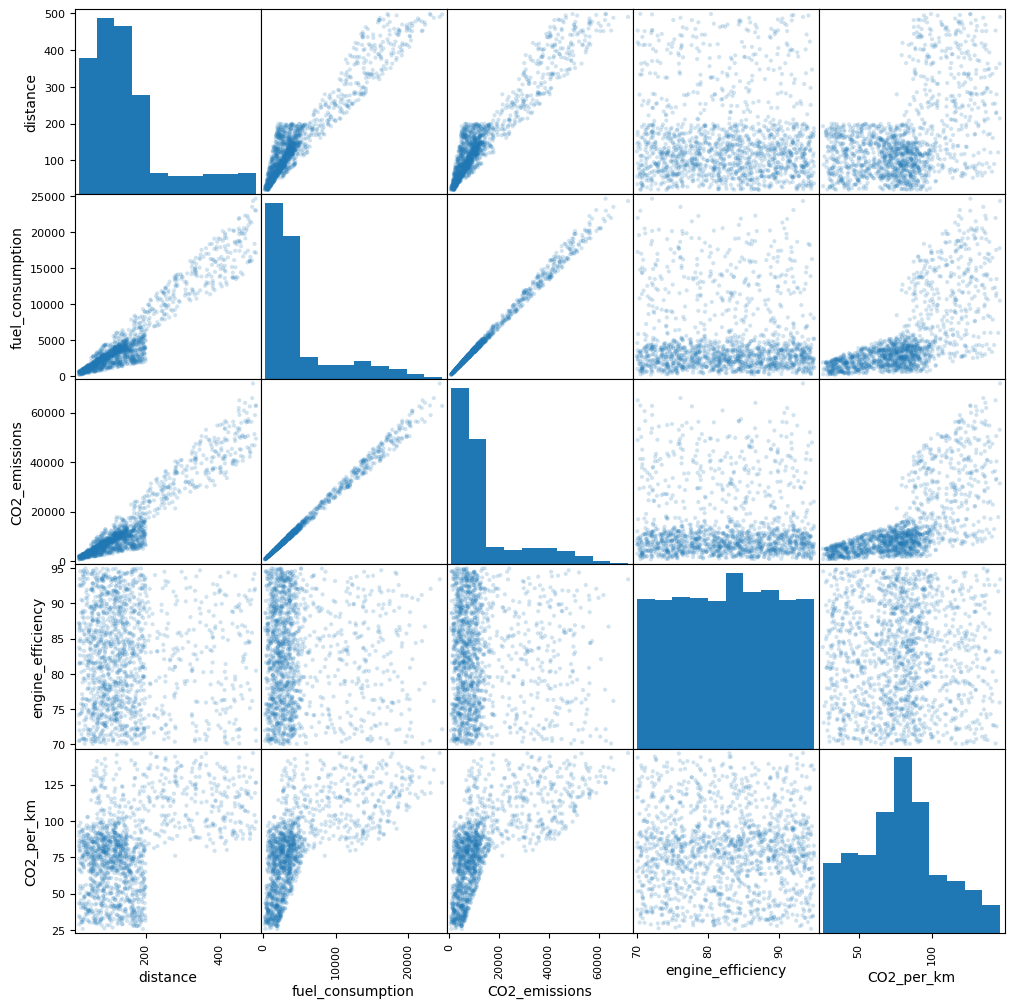

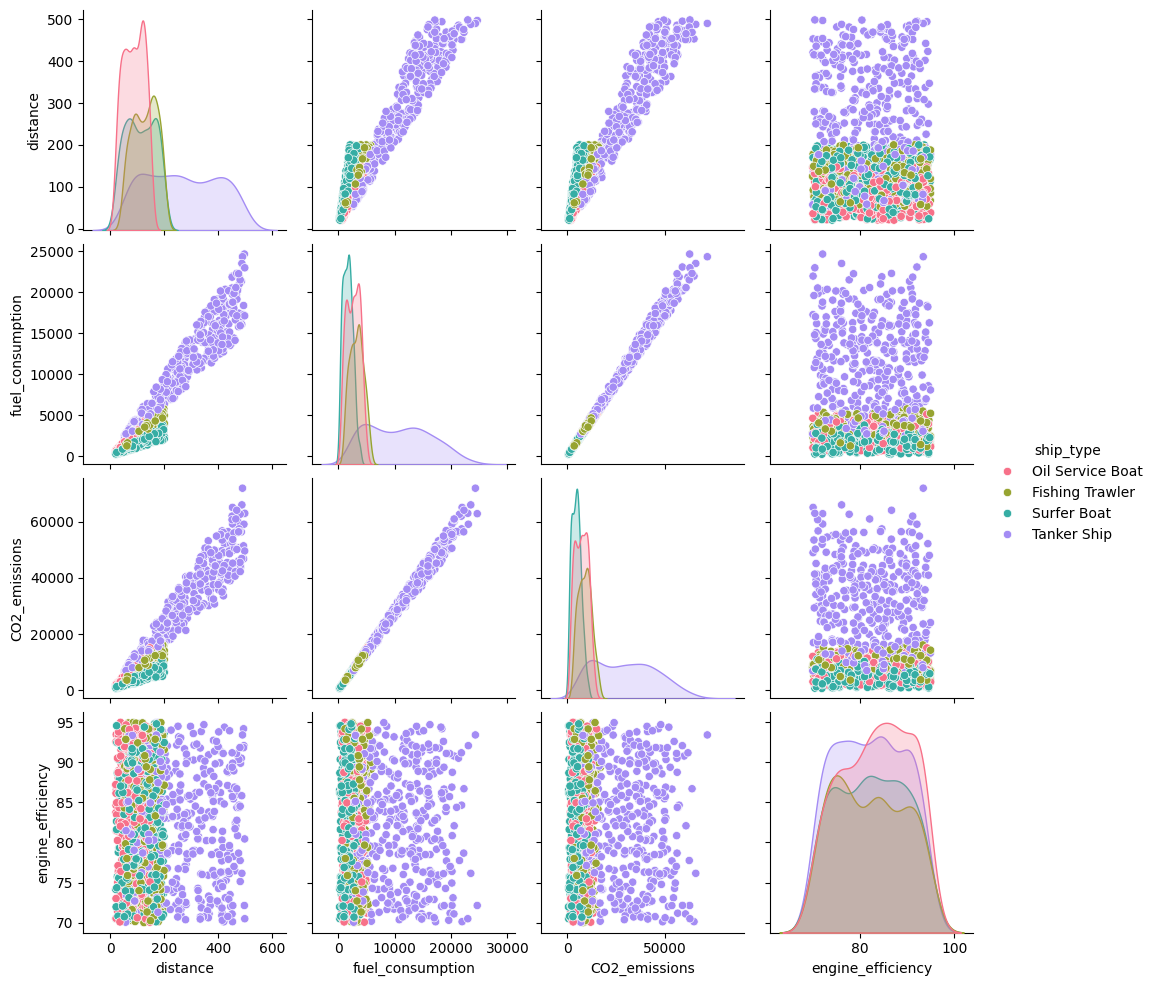

In [129]:
all_features = ['ship_type', 'fuel_type', 'weather_conditions', 'month', 'distance', 'fuel_consumption', 'CO2_emissions', 'engine_efficiency', 'CO2_per_km']

scatter_matrix(df, alpha = 0.2, figsize = (12, 12), diagonal = 'hist')
plt.show()

sns.pairplot(df, hue='ship_type', vars=['distance', 'fuel_consumption', 'CO2_emissions', 'engine_efficiency'], palette="husl")
plt.show()

#### Основываясь на приведённых выше графиках зависимостей, можно сделать однозначный вывод о **2 кластерах:** это тип судна Tanker ship и все остальные типы судов
Прменим метод K-means к нашему датасету

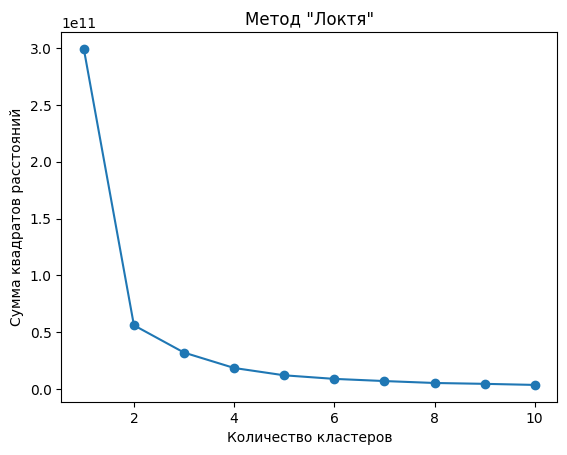

In [130]:
from sklearn.cluster import KMeans

categorical_features = ['ship_type', 'fuel_type', 'weather_conditions', 'month']
numerical_features = ['distance', 'fuel_consumption', 'CO2_emissions', 'engine_efficiency', 'CO2_per_km']

def categorical_to_numerical_process(dataframe, column):
    
    def convert_to_index(value, uniq_values):
        return uniq_values.index(value)
        
    lists_uniq_values = sorted(list(set(dataframe[column])))
    dataframe[column] = dataframe[column].apply(lambda x: convert_to_index(x, lists_uniq_values))
    
for feature in categorical_features:
    categorical_to_numerical_process(df, feature)

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[:-1])
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Метод "Локтя"')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.show()

#### Метод "Локтя" помог нам определить, что, действительно, оптимальным вариантом будет 2 кластера

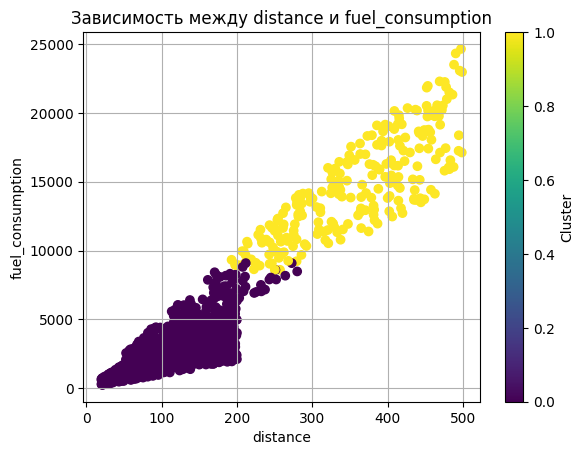

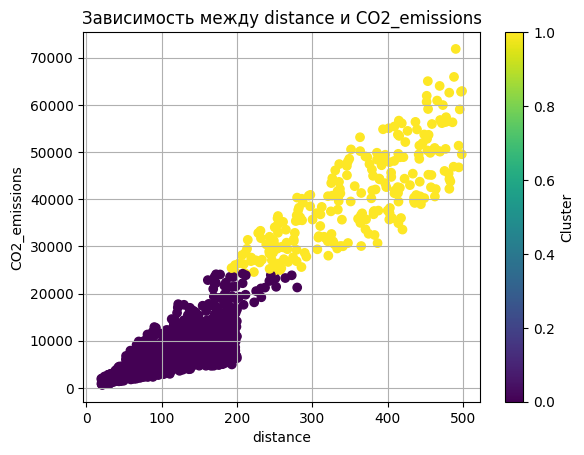

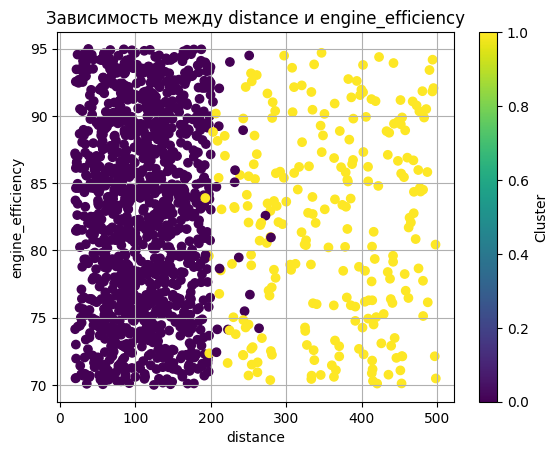

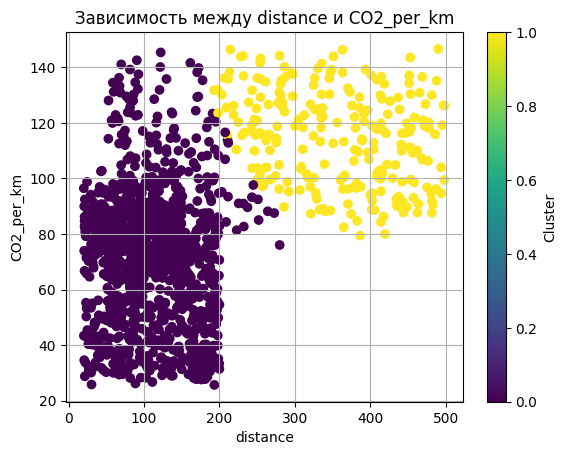

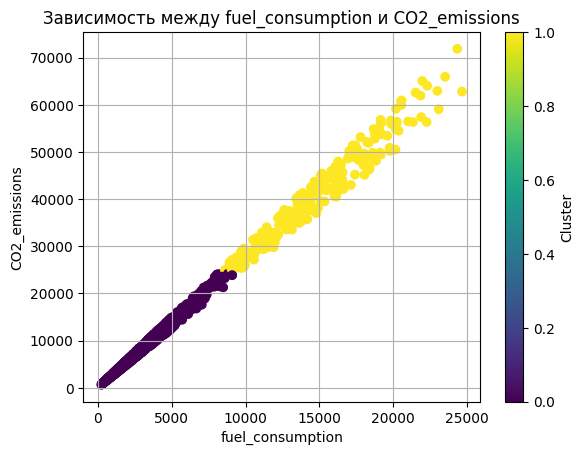

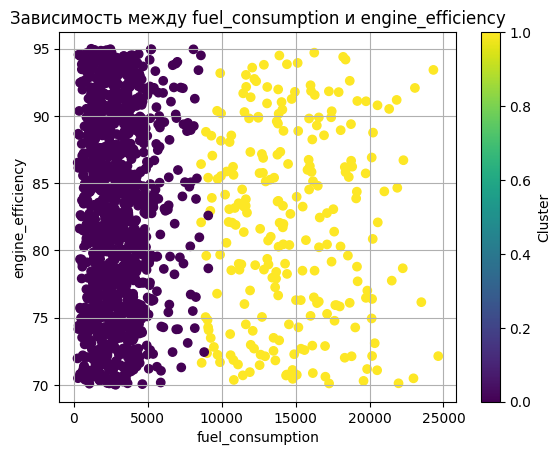

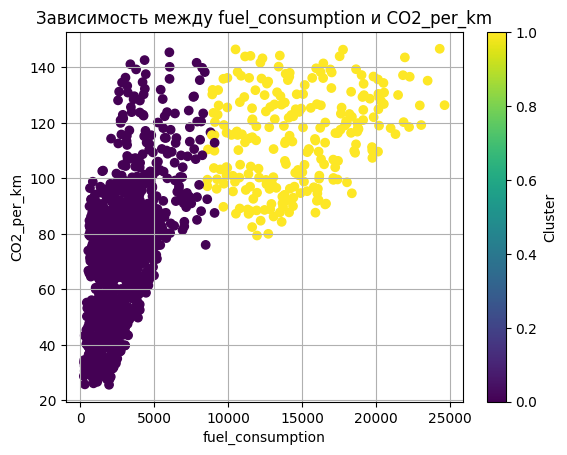

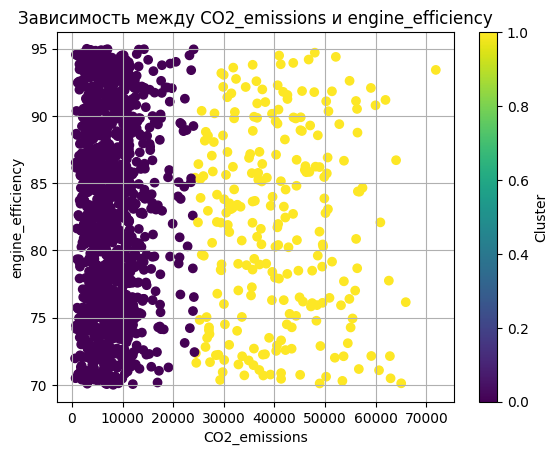

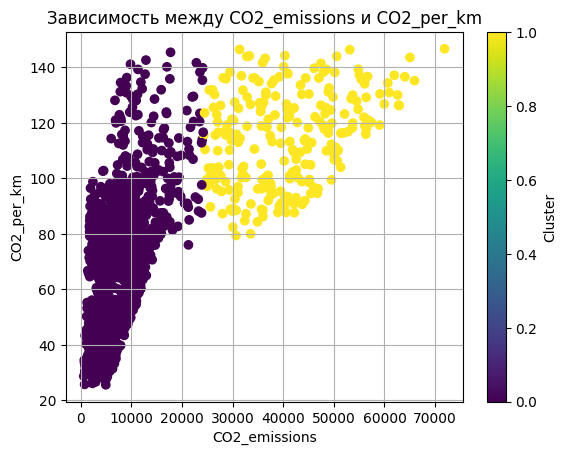

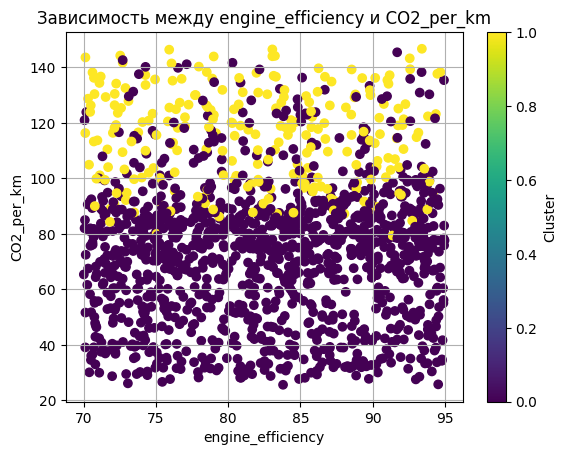

In [145]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[numerical_features])

clusters = kmeans.predict(df[numerical_features])
df['Cluster'] = clusters

for (feature1, feature2) in itertools.combinations(numerical_features, 2):
    plt.scatter(df[feature1], df[feature2], c=df['Cluster'],
                cmap='viridis', label='Clusters')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Зависимость между {feature1} и {feature2}')
    plt.colorbar(label='Cluster')
    plt.grid()
    plt.show()

### Вывод
В этой работе мы проанализировали датасет на количество кластеров и чётко выявили 2 кластера. Почему именно такие кластеры? Очевидно, что судно типа "Танкер" резко отличается по своим характеристикам: он ходит на гораздо более длинные расстояния и, соответственно, потребляет больше топлива, производит больше выбросов CO2 и т.д. На фоне этого три остальных вида судов объединяются в один отдельный кластер.